# Data Preparation: Explore Temporal Structure

We have explored and prepared our time series data, performed necessary transformations, now its time to investigate the temporal structure including the predictive power of the data.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
plt.style.use("seaborn-whitegrid")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## White Noise

If the series is white noise, this is just a series of random numbers and cannot be predicted. The following conditions have to be investigated to detect white noise.

- Check if series have a zero mean
- Check if the variance is constant over time
- Check if the correlation is 0 with lagged values

Let’s explore the statistical tools which can help us in detecting white noise.

- Summary statistics: Check and compare the mean and variance of the entire time series against different time intervals.
- Line plot: Line plot will give us a basic idea about inconsistent mean and variance over time.
- Autocorrelation plot: Check the strength of the correlation between lagged observations.

We will discuss the above tools using a synthetically created white noise time series data. We will create this variable using a gaussian distribution with mean 0 and standard deviation 1.

In [2]:
# create white noise
white_noise = pd.Series(np.random.randn(1000))
white_noise.head()

0    0.357367
1    0.740456
2   -1.076037
3    1.229005
4    0.431353
dtype: float64

In [3]:
# summary statistics
white_noise.describe()

count    1000.000000
mean        0.020860
std         0.993280
min        -2.698772
25%        -0.638504
50%         0.010141
75%         0.710460
max         2.694838
dtype: float64

Now, look at the summary statistics, mean is nearly 0 and the standard deviation is 1, this is expected in this example. In real life after looking at this summary, series can be distributed in multiple sub-series and respective statistics can be compared for any inconsistency in mean and variance over time.

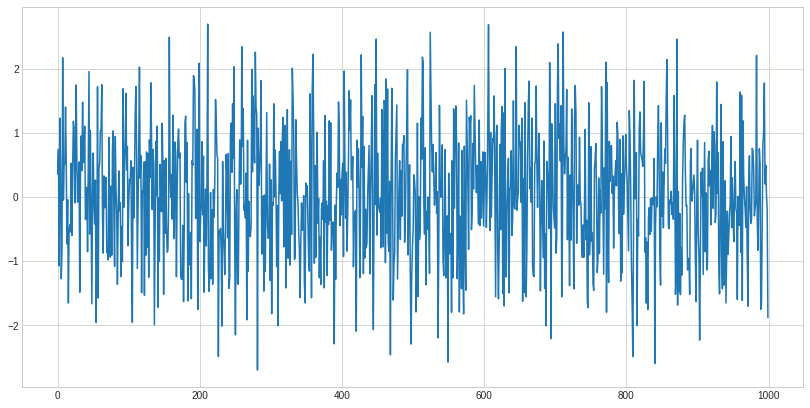

In [4]:
# line plot
plt.figure(figsize=(14,7))
white_noise.plot()
plt.show()

Histogram with a bell-shaped curve confirms the Gaussian distribution with mean 0 and variance 1. Again, we can validate this distribution for different time intervals.

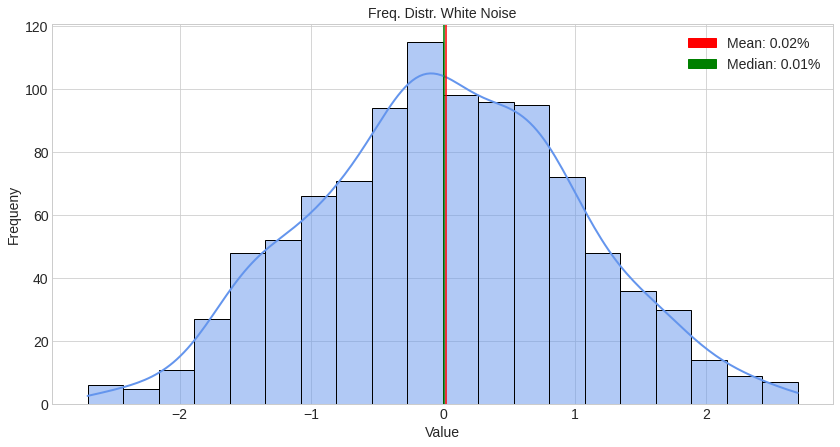

In [5]:
# histogram plot
plt.figure(figsize=(14,7))

sns.histplot(white_noise, 
             kde=True, 
             bins=20,
             color="cornflowerblue",
             line_kws={"linewidth": 2})

mean = white_noise.mean()
median = white_noise.median()
plt.axvline(x=mean, c="r")
plt.axvline(x=median, c="g")
mean_patch = mpatches.Patch(color="r", label="Mean: {}%".format(np.around(mean,2)))
median_patch = mpatches.Patch(color="g", label="Median: {}%".format(np.around(median,2)))

plt.legend(handles=[mean_patch, median_patch], fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.ylabel("Frequeny", fontsize=14)
plt.title("Freq. Distr. White Noise", fontsize=14)

plt.show()

Finally, we can investigate the strength of the correlation between lagged observations using the autocorrelation plot.

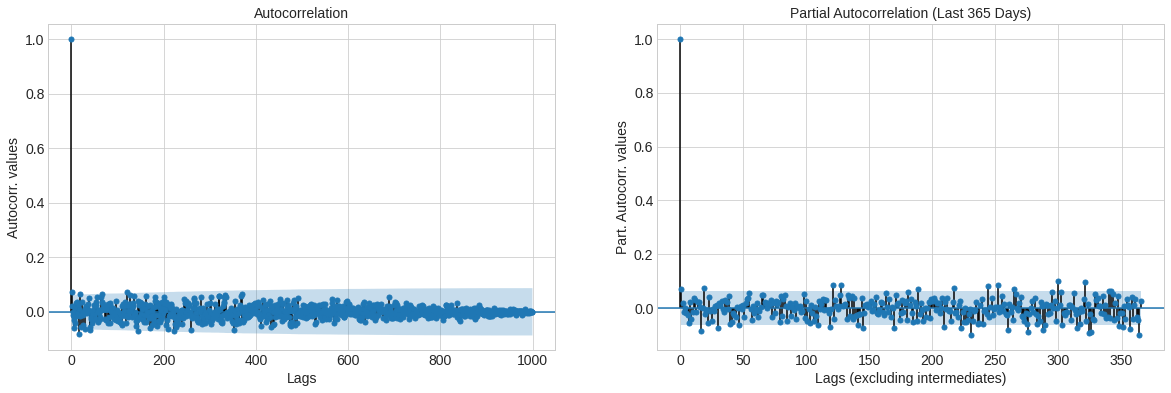

In [6]:
# plot autocorrelations & partial autocorrelation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plot_acf(white_noise.tolist(), lags=white_noise.shape[0]-1, ax=axes[0])
axes[0].set_title("Autocorrelation", fontsize=14)
axes[0].set_xlabel('Lags', fontsize=14)
axes[0].set_ylabel('Autocorr. values', fontsize=14)
plt.setp(axes[0].get_xticklabels(), fontsize=14)
plt.setp(axes[0].get_yticklabels(), fontsize=14)

plot_pacf(white_noise.tolist(), lags=365, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (Last 365 Days)", fontsize=14)
axes[1].set_xlabel('Lags (excluding intermediates)', fontsize=14)
axes[1].set_ylabel('Part. Autocorr. values', fontsize=14)
plt.setp(axes[1].get_xticklabels(), fontsize=14)
plt.setp(axes[1].get_yticklabels(), fontsize=14)

plt.show()

We can see there is no correlation between lagged observations. Therefore, we can conclude this series is white noise and cannot be predicted well.

## Random Walk

A random walk is a series in which changes from one time period (t) to the next (t+1) are random. The process used in generating a random walk forces dependency from one time step to the next, we can understand this dependency with the following equation, where X(t) is the next value in the series, X(t-1) is the value at the previous time step and e(t) is the white noise at next time.

$ X(t) = X(t-1) + e(t) $

The simplest random walk to understand is a 1-dimensional walk. Suppose that the black dot below is sitting on a number line. The black dot starts in the center. 

<img src="https://raw.githubusercontent.com/lucaskienast/Time-Series-Analysis/main/1)%20Data%20Preparation/Random%20Walk%20Number%20Line.png">

Then, it takes a step, either forward or backward, with equal probability. It keeps taking steps either forward or backward each time. Let’s call the 1st step a₁, the second step a₂, the third step a₃, and so on. Each “a” is either equal to +1 (if the step is forward) or -1 (if the step is backward).

<img src="https://raw.githubusercontent.com/lucaskienast/Time-Series-Analysis/main/1)%20Data%20Preparation/Random%20Walk%20Steps.png">

Now, we will simulate a random walk using the same approach and plot these observations on a line.


In [7]:
# create random walk
steps_n = 1000
step_options = [-1, 1]
origin = np.zeros((1,1))
steps = np.random.choice(a=step_options, size=(steps_n, 1))
random_walk = pd.Series(np.concatenate([origin, steps]).cumsum())
random_walk

0       0.0
1       1.0
2       0.0
3       1.0
4       2.0
       ... 
996     6.0
997     5.0
998     6.0
999     7.0
1000    8.0
Length: 1001, dtype: float64

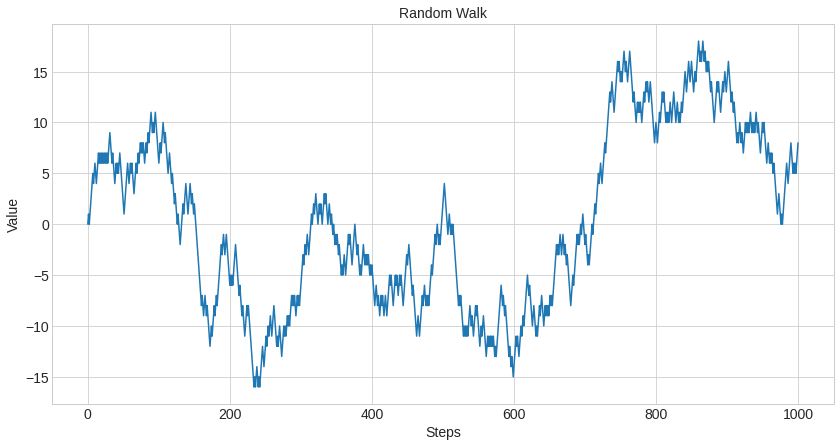

In [8]:
# plot random walk
plt.figure(figsize=(14,7))
random_walk.plot()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("Random Walk", fontsize=14)
plt.show()

We can see this shape looks like a movement of real stock index.
Now, let’s explore the tools which can help us in identifying a random walk within any time series.

## Autocorrelation Plot

We know how random walk is created, so by its design, we expect a very high correlation with the previous observation and gradually this correlation will be reduced.

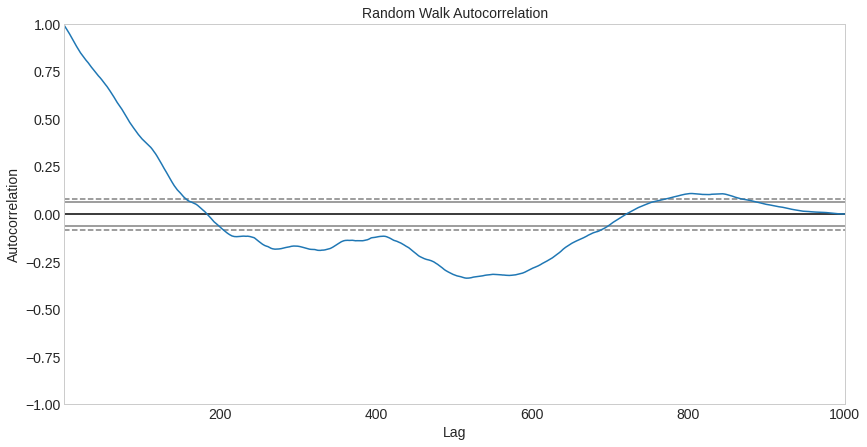

In [9]:
# plot autocorrelation
plt.figure(figsize=(14,7))
autocorrelation_plot(random_walk)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.title("Random Walk Autocorrelation", fontsize=14)
plt.show()

## ADF & KPSS Tests (to confirm non-stationarity)

The way random walk is created, the series expected to be non-stationary, i.e., inconsistency in mean and variance over time.

In [10]:
# ADF (H0: non-stationary)
def adf_stationarity_test(signal):
  result_adf = adfuller(signal, autolag="AIC")
  statistic = result_adf[0]
  p_value = result_adf[1]
  used_lag = result_adf[2]
  nobs = result_adf[3]
  critical_values = result_adf[4]
  icbest = result_adf[5]
  print("________________________________")
  print(" > ADF: Is the data stationary ?")
  print(f'ADF Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {used_lag}')
  print('Critial Values:')

  for key, value in critical_values.items():
      print(f'   {key}, {value}')  

  print(f'\nResult: The series is likely {"not " if p_value > 0.05 else ""}stationary')
  print("________________________________")

In [11]:
# KPSS test around constant (H0: stationary around constant)
def kpss_constant_stationarity_test(signal):
  result_kpss_c = kpss(signal, regression="c")

  statistic = result_kpss_c[0]
  p_value = result_kpss_c[1]
  n_lags = result_kpss_c[2]
  critical_values = result_kpss_c[3]

  print("________________________________")
  print(" > KPSS: Is the data stationary around a constant ?")
  print(f'KPSS Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')
  print('Critial Values:')

  for key, value in critical_values.items():
    print(f'   {key} : {value}')
    
  print(f'\nResult: The series is likely {"not " if p_value < 0.05 else ""}stationary around a constant')
  print("________________________________")

In [12]:
# KPSS test around trend (H0: stationary around trend)
def kpss_trend_stationarity_test(signal):
  result_kpss_ct = kpss(signal, regression="ct")

  statistic = result_kpss_ct[0]
  p_value = result_kpss_ct[1]
  n_lags = result_kpss_ct[2]
  critical_values = result_kpss_ct[3]

  print("________________________________")
  print(" > KPSS: Is the data stationary around a trend ?")
  print(f'KPSS Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')
  print('Critial Values:')

  for key, value in critical_values.items():
    print(f'   {key} : {value}')
    
  print(f'\nResult: The series is likely {"not " if p_value < 0.05 else ""}stationary around a trend')
  print("________________________________")

In [13]:
adf_stationarity_test(random_walk)
kpss_constant_stationarity_test(random_walk)
kpss_trend_stationarity_test(random_walk)

________________________________
 > ADF: Is the data stationary ?
ADF Statistic: -1.7297531220821525
p-value: 0.4158516256771077
num lags: 0
Critial Values:
   1%, -3.4369061654329998
   5%, -2.86443457404
   10%, -2.568311209

Result: The series is likely not stationary
________________________________
________________________________
 > KPSS: Is the data stationary around a constant ?
KPSS Statistic: 1.335621394750723
p-value: 0.01
num lags: 22
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739

Result: The series is likely not stationary around a constant
________________________________
________________________________
 > KPSS: Is the data stationary around a trend ?
KPSS Statistic: 0.6529418731705924
p-value: 0.01
num lags: 22
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216

Result: The series is likely not stationary around a trend
________________________________


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
